# Summary of this notebook

In this notebook, we train Convolutional Neural Networks (CNNs) on the various satellite image channels to predict whether a given village is in the poorest third of all villages.  After setting up the appropriate TensorFlow image dataset generators, we begin by training custom-architected CNNs on RGB and SWIR1 images.  Since these models do not perform well, we thereafter employ transfer learning: We train the final layer of `EfficientNetV2M`, a large image-processing CNN trained on [imagenet](https://www.image-net.org/).

We train different versions of `EfficientNetV2M` on each of the image types: RGB, NIR, SWIR1, SWIR2, TEMP1 and NIGHTLIGHTS.  We then export the predictions of each of these models, in the form of probabilities of being in the poorest third of all villages, in dataframes for the `train`, `test` and `val` datasets.  This enables us to create ensemble models (in the [next notebook](./06_final_modeling.ipynb)) using these predicted probabilities and other features.

Throughout this notebook, we train models on the `train` data and use the `test` data for comparison and early stopping.  We then make *predictions* for all three of the `train`, `test` and `val` datasets, but we do not *use* the `val` dataset in any way that could influence our modeling choices.

In [ ]:
#If using Google Colab and Google Drive, run the following commands

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#REPLACE THIS COMMAND WITH THE APPROPRIATE PATH TO THE "code" FOLDER ON YOUR GOOGLE DRIVE
%cd ./drive/MyDrive/poverty_project/group_project/code

/content/drive/MyDrive/poverty_project/group_project/code


## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Input, Rescaling, GlobalAveragePooling2D, Resizing
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.optimizers import Adam

from sklearn import metrics

from os import listdir
from os.path import isfile, join
import os
import itertools

### Read in the non-image data

In [ ]:
train_csv_location = '../data/train.csv'
test_csv_location = '../data/test.csv'
val_csv_location = '../data/val.csv'

In [ ]:
train = pd.read_csv(train_csv_location, index_col='index')
train.head()

,country,year,wealth_index,is_urban,households,latitude,longitude,is_poorest
index,,,,,,,,
lesotho_2014_00-254,lesotho,2014.0,0.983558,1.0,24.0,-28.909042,27.936529,0
burkina_faso_2010_00-162,burkina_faso,2010.0,-0.604069,0.0,25.0,11.163129,-3.322228,1
mali_2012_00-381,mali,2012.0,-0.371823,0.0,25.0,11.877264,-6.966146,0
lesotho_2009_00-237,lesotho,2009.0,-0.110702,0.0,23.0,-29.518770,28.033241,0
zimbabwe_2010_00-125,zimbabwe,2010.0,-0.749686,0.0,28.0,-16.217611,30.610455,1


In [ ]:
test = pd.read_csv(test_csv_location, index_col='index')
val = pd.read_csv(val_csv_location, index_col='index')

## Tensorflow image dataset generators for RGB images

In [ ]:
rgb_image_path = '../data/dhs_images_separated/RGB'

In [ ]:
rgb_train_ds = image_dataset_from_directory(
    f"{rgb_image_path}/train",
    label_mode = 'binary',
    batch_size = 32,
    seed = 42, 
    image_size=[255,255]
)

Found 17520 files belonging to 2 classes.


In [ ]:
rgb_test_ds = image_dataset_from_directory(
    f"{rgb_image_path}/test",
    label_mode = 'binary',
    batch_size = 32,
    seed = 42, 
    image_size=[255,255]
)

Found 974 files belonging to 2 classes.


In [ ]:
rgb_val_ds = image_dataset_from_directory(
    f"{rgb_image_path}/val",
    label_mode = 'binary',
    batch_size = 32,
    seed = 42, 
    image_size=[255,255]
)

Found 973 files belonging to 2 classes.


## Tensorflow image dataset generators for NIGHTLIGHTS images

The NIGHTLIGHTS images come from different satellites than the others (all of which come from LANDSAT).  The NIGHTLIGHTS images were captured at 8x8 resolution (from the DMSP satellite, in the years 2009-2011) or 16x16 resolution (from the VIIRS satellite, in the years 2012-2017) and then scaled up to 255x255 pixels when downloaded in the `.tfrecord.gz` files.

As such, we can save computational time and resources by scaling these images down to their original (smaller) resolutions.  However, in order to ensure consistency across the images from the DMSP and VIIRS satellites, we rescale *all* NIGHTLIGHTS images down to 8x8 resolution.

In [ ]:
nl_image_path = '../data/dhs_images_separated/NIGHTLIGHTS'

#Resize all images to be 8x8, fitting with the lowest resolution found among
#the original NIGHTLIGHTS images (2009-2011)
nl_image_resize = [8,8]

In [ ]:
nl_train_ds = image_dataset_from_directory(
    f"{nl_image_path}/train",
    label_mode = 'binary',
    batch_size = 32,
    seed = 42, 
    image_size = nl_image_resize,
)

Found 17520 files belonging to 2 classes.


In [ ]:
nl_test_ds = image_dataset_from_directory(
    f"{nl_image_path}/test",
    label_mode = 'binary',
    batch_size = 32,
    seed = 42, 
    image_size = nl_image_resize,
)

Found 974 files belonging to 2 classes.


In [ ]:
nl_val_ds = image_dataset_from_directory(
    f"{nl_image_path}/val",
    label_mode = 'binary',
    batch_size = 32,
    seed = 42, 
    image_size = nl_image_resize
)

Found 973 files belonging to 2 classes.


## Tensorflow image dataset generators from NIR, SWIR1, SWIR2 and TEMP1 channels

In [ ]:
NIR_image_path = '../data/dhs_images_separated/NIR'
SWIR1_image_path = '../data/dhs_images_separated/SWIR1'
SWIR2_image_path = '../data/dhs_images_separated/SWIR2'
TEMP1_image_path = '../data/dhs_images_separated/TEMP1'

In [ ]:
channels = ['NIR', 'SWIR1', 'SWIR2', 'TEMP1']
kinds = ['train', 'test', 'val']

for kind, channel in itertools.product(kinds, channels):
    #Get the path to the images from this channel
    image_path = locals()[f"{channel}_image_path"]

    #Make the Tensorflow image dataset generator object for this kind and channel
    locals()[f"{channel}_{kind}_ds"] =  image_dataset_from_directory(
                                               f"{image_path}/{kind}",
                                               label_mode = 'binary',
                                               batch_size = 32,
                                               seed = 42, 
                                               image_size=[255,255]
                                              )

Found 17520 files belonging to 2 classes.
Found 17520 files belonging to 2 classes.
Found 17520 files belonging to 2 classes.
Found 17520 files belonging to 2 classes.
Found 974 files belonging to 2 classes.
Found 974 files belonging to 2 classes.
Found 974 files belonging to 2 classes.
Found 974 files belonging to 2 classes.
Found 973 files belonging to 2 classes.
Found 973 files belonging to 2 classes.
Found 973 files belonging to 2 classes.
Found 973 files belonging to 2 classes.


# Building Convolutional Neural Netork Models

## End-to-end CNN for RGB classification

First, we'll try building *our own* CNN architecture to predict from an RGB image whether a given village falls in the poorest third of all villages.

In [ ]:
model = Sequential()

#Input layer
model.add(layers.Input(shape=(255,255,3)))

# 5 convolutional / MaxPooling layers with 3x3 filters: Get down to a 7x7 image with 16 channels
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2) ))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2) ))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2) ))

model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2) ))

model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2) ))

#Flatten
model.add(Flatten())

#Dense network - with .3 probability of dropout
model.add(Dense(512, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(8, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(1, activation='sigmoid'))



#Compile the model
model.compile(optimizer='adam',
              loss='bce',
              metrics=['acc'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

In [ ]:
model_name = 'rgb_classification_endtoend_1'
model_save_path = '../models'

In [ ]:
#Add a callback to save the model each epoch
checkpoint = ModelCheckpoint(f"{model_save_path}/{model_name}", save_freq='epoch', verbose=0)

In [ ]:
#Add early stopping
es = EarlyStopping( patience = 5)

In [ ]:
res = model.fit(rgb_train_ds,
                epochs = 50,
                validation_data = rgb_test_ds,
                verbose = 1,
                callbacks = [es, checkpoint]
                )

Epoch 1/50
548/548 [==============================] - ETA: 0s - loss: 0.6277 - acc: 0.6630

548/548 [==============================] - 604s 765ms/step - loss: 0.6277 - acc: 0.6630 - val_loss: 0.6141 - val_acc: 0.6632
Epoch 2/50
547/548 [============================>.] - ETA: 0s - loss: 0.5869 - acc: 0.6653

548/548 [==============================] - 14s 25ms/step - loss: 0.5869 - acc: 0.6653 - val_loss: 0.5695 - val_acc: 0.6632
Epoch 3/50
547/548 [============================>.] - ETA: 0s - loss: 0.5790 - acc: 0.6674

548/548 [==============================] - 14s 25ms/step - loss: 0.5792 - acc: 0.6674 - val_loss: 0.5697 - val_acc: 0.6653
Epoch 4/50
546/548 [============================>.] - ETA: 0s - loss: 0.5733 - acc: 0.6741

548/548 [==============================] - 14s 25ms/step - loss: 0.5732 - acc: 0.6741 - val_loss: 0.5586 - val_acc: 0.7064
Epoch 5/50
548/548 [==============================] - ETA: 0s - loss: 0.5591 - acc: 0.6882

548/548 [==============================] - 14s 25ms/step - loss: 0.5591 - acc: 0.6882 - val_loss: 0.5518 - val_acc: 0.6930
Epoch 6/50
547/548 [============================>.] - ETA: 0s - loss: 0.5531 - acc: 0.6936

548/548 [==============================] - 14s 24ms/step - loss: 0.5531 - acc: 0.6935 - val_loss: 0.5523 - val_acc: 0.6971
Epoch 7/50
548/548 [==============================] - ETA: 0s - loss: 0.5522 - acc: 0.6909

548/548 [==============================] - 14s 25ms/step - loss: 0.5522 - acc: 0.6909 - val_loss: 0.5523 - val_acc: 0.7023
Epoch 8/50
546/548 [============================>.] - ETA: 0s - loss: 0.5430 - acc: 0.6995

548/548 [==============================] - 13s 24ms/step - loss: 0.5431 - acc: 0.6994 - val_loss: 0.5587 - val_acc: 0.6899
Epoch 9/50
545/548 [============================>.] - ETA: 0s - loss: 0.5366 - acc: 0.7011

548/548 [==============================] - 14s 25ms/step - loss: 0.5365 - acc: 0.7011 - val_loss: 0.5577 - val_acc: 0.6899
Epoch 10/50
547/548 [============================>.] - ETA: 0s - loss: 0.5278 - acc: 0.7097

548/548 [==============================] - 14s 24ms/step - loss: 0.5277 - acc: 0.7099 - val_loss: 0.5529 - val_acc: 0.7002


So our custom-built architecture only achieved about 70% accuracy when trained on the RGB images.  This is not much better than the baseline accuracy!  Let's try training the model on a different satellite image channel to see if it does any better.

## Training the same model on only SWIR1 data

In [ ]:
SWIR1_test_ds = image_dataset_from_directory(
    f"{SWIR1_image_path}/test",
    label_mode = 'binary',
    batch_size = 32,
    seed = 42, 
    image_size=[255,255]
)

Found 974 files belonging to 2 classes.


In [ ]:
model_name = 'SWIR1_classification_endtoend_1'
model_save_path = '../models'

In [ ]:
#Add a callback to save the model each epoch
checkpoint = ModelCheckpoint(f"{model_save_path}/{model_name}", save_freq='epoch', verbose=0)

In [ ]:
#Add early stopping
es = EarlyStopping( patience = 5)

In [ ]:
res = model.fit(SWIR1_train_ds,
                epochs = 50,
                validation_data = SWIR1_test_ds,
                verbose = 1,
                callbacks = [es, checkpoint]
                )

Epoch 1/50
546/548 [============================>.] - ETA: 1s - loss: 0.6361 - acc: 0.6631

548/548 [==============================] - 579s 763ms/step - loss: 0.6362 - acc: 0.6630 - val_loss: 0.6243 - val_acc: 0.6632
Epoch 2/50
545/548 [============================>.] - ETA: 0s - loss: 0.6192 - acc: 0.6643

548/548 [==============================] - 14s 25ms/step - loss: 0.6193 - acc: 0.6644 - val_loss: 0.6114 - val_acc: 0.6632
Epoch 3/50
545/548 [============================>.] - ETA: 0s - loss: 0.6189 - acc: 0.6639

548/548 [==============================] - 14s 25ms/step - loss: 0.6186 - acc: 0.6640 - val_loss: 0.6136 - val_acc: 0.6632
Epoch 4/50
546/548 [============================>.] - ETA: 0s - loss: 0.6169 - acc: 0.6644

548/548 [==============================] - 14s 25ms/step - loss: 0.6169 - acc: 0.6645 - val_loss: 0.6165 - val_acc: 0.6632
Epoch 5/50
545/548 [============================>.] - ETA: 0s - loss: 0.6083 - acc: 0.6663

548/548 [==============================] - 14s 25ms/step - loss: 0.6084 - acc: 0.6667 - val_loss: 0.6124 - val_acc: 0.6632
Epoch 6/50
547/548 [============================>.] - ETA: 0s - loss: 0.6065 - acc: 0.6641

548/548 [==============================] - 14s 25ms/step - loss: 0.6065 - acc: 0.6640 - val_loss: 0.6106 - val_acc: 0.6632
Epoch 7/50
547/548 [============================>.] - ETA: 0s - loss: 0.6334 - acc: 0.6649

548/548 [==============================] - 14s 25ms/step - loss: 0.6334 - acc: 0.6649 - val_loss: 0.6390 - val_acc: 0.6632
Epoch 8/50
547/548 [============================>.] - ETA: 0s - loss: 0.6376 - acc: 0.6655

548/548 [==============================] - 14s 25ms/step - loss: 0.6377 - acc: 0.6654 - val_loss: 0.6389 - val_acc: 0.6632
Epoch 9/50
545/548 [============================>.] - ETA: 0s - loss: 0.6375 - acc: 0.6654

548/548 [==============================] - 14s 25ms/step - loss: 0.6375 - acc: 0.6654 - val_loss: 0.6389 - val_acc: 0.6632
Epoch 10/50
546/548 [============================>.] - ETA: 0s - loss: 0.6378 - acc: 0.6651

548/548 [==============================] - 14s 25ms/step - loss: 0.6376 - acc: 0.6654 - val_loss: 0.6389 - val_acc: 0.6632
Epoch 11/50
546/548 [============================>.] - ETA: 0s - loss: 0.6377 - acc: 0.6654

548/548 [==============================] - 14s 25ms/step - loss: 0.6376 - acc: 0.6654 - val_loss: 0.6389 - val_acc: 0.6632


So the same model performed *slightly worse than the baseline accuracy* when trained on the SWIR1 image channel only.

Perhaps this is an issue with our custom-built CNN architecture.  Would a pretrained CNN work better on our image data?  Let's try `EfficientNetV2M` with our RGB images:

## Using a pre-trained network on RGB data: `EfficientNetV2M`

In [ ]:
effnet = EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_shape=(255,255,3),
    classes=2,
    classifier_activation="softmax",
    include_preprocessing=True,
)

In [ ]:
effnet.trainable = False

In [ ]:
model = Sequential()

model.add(effnet)
model.add(GlobalAveragePooling2D())

#Just use a single output layer
model.add(Dense(1, activation='sigmoid'))


#Compile the model
model.compile(optimizer='adam',
              loss='bce',
              metrics=['acc'])

In [ ]:
model_name = 'rgb_classification_effnet_1'
model_save_path = '../models'

In [ ]:
#Add a callback to save the model each epoch
checkpoint = ModelCheckpoint(f"{model_save_path}/{model_name}", save_freq='epoch', verbose=0)

In [ ]:
#Add early stopping
es = EarlyStopping( patience = 5)

In [ ]:
res = model.fit(rgb_train_ds,
                epochs = 50,
                validation_data = rgb_test_ds,
                verbose = 1,
                callbacks = [es, checkpoint]
                )

Epoch 1/50
548/548 [==============================] - ETA: 0s - loss: 0.5608 - acc: 0.7005

548/548 [==============================] - 573s 991ms/step - loss: 0.5608 - acc: 0.7005 - val_loss: 0.5373 - val_acc: 0.7136
Epoch 2/50
547/548 [============================>.] - ETA: 0s - loss: 0.5365 - acc: 0.7173

548/548 [==============================] - 181s 330ms/step - loss: 0.5365 - acc: 0.7172 - val_loss: 0.5306 - val_acc: 0.7146
Epoch 3/50
547/548 [============================>.] - ETA: 0s - loss: 0.5296 - acc: 0.7185

548/548 [==============================] - 183s 334ms/step - loss: 0.5297 - acc: 0.7185 - val_loss: 0.5201 - val_acc: 0.7402
Epoch 4/50
547/548 [============================>.] - ETA: 0s - loss: 0.5232 - acc: 0.7243

548/548 [==============================] - 181s 331ms/step - loss: 0.5232 - acc: 0.7243 - val_loss: 0.5176 - val_acc: 0.7310
Epoch 5/50
547/548 [============================>.] - ETA: 0s - loss: 0.5213 - acc: 0.7262

548/548 [==============================] - 184s 337ms/step - loss: 0.5212 - acc: 0.7262 - val_loss: 0.5163 - val_acc: 0.7392
Epoch 6/50
547/548 [============================>.] - ETA: 0s - loss: 0.5173 - acc: 0.7309

548/548 [==============================] - 184s 336ms/step - loss: 0.5175 - acc: 0.7308 - val_loss: 0.5122 - val_acc: 0.7413
Epoch 7/50
547/548 [============================>.] - ETA: 0s - loss: 0.5155 - acc: 0.7301

548/548 [==============================] - 183s 334ms/step - loss: 0.5155 - acc: 0.7303 - val_loss: 0.5107 - val_acc: 0.7402
Epoch 8/50
547/548 [============================>.] - ETA: 0s - loss: 0.5158 - acc: 0.7302

548/548 [==============================] - 184s 335ms/step - loss: 0.5159 - acc: 0.7302 - val_loss: 0.5094 - val_acc: 0.7433
Epoch 9/50
547/548 [============================>.] - ETA: 0s - loss: 0.5132 - acc: 0.7342

548/548 [==============================] - 185s 337ms/step - loss: 0.5131 - acc: 0.7342 - val_loss: 0.5112 - val_acc: 0.7331
Epoch 10/50
547/548 [============================>.] - ETA: 0s - loss: 0.5144 - acc: 0.7309

548/548 [==============================] - 184s 336ms/step - loss: 0.5143 - acc: 0.7310 - val_loss: 0.5076 - val_acc: 0.7423
Epoch 11/50
547/548 [============================>.] - ETA: 0s - loss: 0.5110 - acc: 0.7311

548/548 [==============================] - 185s 337ms/step - loss: 0.5109 - acc: 0.7313 - val_loss: 0.5088 - val_acc: 0.7341
Epoch 12/50
547/548 [============================>.] - ETA: 0s - loss: 0.5097 - acc: 0.7325

548/548 [==============================] - 184s 337ms/step - loss: 0.5097 - acc: 0.7325 - val_loss: 0.5061 - val_acc: 0.7372
Epoch 13/50
547/548 [============================>.] - ETA: 0s - loss: 0.5099 - acc: 0.7330

548/548 [==============================] - 188s 343ms/step - loss: 0.5099 - acc: 0.7330 - val_loss: 0.5062 - val_acc: 0.7402
Epoch 14/50
547/548 [============================>.] - ETA: 0s - loss: 0.5082 - acc: 0.7348

548/548 [==============================] - 182s 332ms/step - loss: 0.5081 - acc: 0.7349 - val_loss: 0.5072 - val_acc: 0.7382
Epoch 15/50
547/548 [============================>.] - ETA: 0s - loss: 0.5085 - acc: 0.7335

548/548 [==============================] - 184s 337ms/step - loss: 0.5083 - acc: 0.7336 - val_loss: 0.5063 - val_acc: 0.7382
Epoch 16/50
547/548 [============================>.] - ETA: 0s - loss: 0.5077 - acc: 0.7377

548/548 [==============================] - 187s 341ms/step - loss: 0.5076 - acc: 0.7378 - val_loss: 0.5069 - val_acc: 0.7331
Epoch 17/50
547/548 [============================>.] - ETA: 0s - loss: 0.5044 - acc: 0.7359

548/548 [==============================] - 187s 342ms/step - loss: 0.5041 - acc: 0.7361 - val_loss: 0.5046 - val_acc: 0.7433
Epoch 18/50
547/548 [============================>.] - ETA: 0s - loss: 0.5061 - acc: 0.7351

548/548 [==============================] - 184s 336ms/step - loss: 0.5062 - acc: 0.7351 - val_loss: 0.5048 - val_acc: 0.7433
Epoch 19/50
547/548 [============================>.] - ETA: 0s - loss: 0.5056 - acc: 0.7387

548/548 [==============================] - 188s 342ms/step - loss: 0.5056 - acc: 0.7388 - val_loss: 0.5044 - val_acc: 0.7464
Epoch 20/50
547/548 [============================>.] - ETA: 0s - loss: 0.5058 - acc: 0.7380

548/548 [==============================] - 184s 336ms/step - loss: 0.5058 - acc: 0.7379 - val_loss: 0.5048 - val_acc: 0.7402
Epoch 21/50
547/548 [============================>.] - ETA: 0s - loss: 0.5042 - acc: 0.7364

548/548 [==============================] - 185s 338ms/step - loss: 0.5040 - acc: 0.7366 - val_loss: 0.5027 - val_acc: 0.7464
Epoch 22/50
547/548 [============================>.] - ETA: 0s - loss: 0.5042 - acc: 0.7390

548/548 [==============================] - 189s 346ms/step - loss: 0.5042 - acc: 0.7390 - val_loss: 0.5022 - val_acc: 0.7444
Epoch 23/50
547/548 [============================>.] - ETA: 0s - loss: 0.5042 - acc: 0.7382

548/548 [==============================] - 185s 338ms/step - loss: 0.5041 - acc: 0.7382 - val_loss: 0.5034 - val_acc: 0.7464
Epoch 24/50
547/548 [============================>.] - ETA: 0s - loss: 0.5024 - acc: 0.7407

548/548 [==============================] - 185s 338ms/step - loss: 0.5023 - acc: 0.7408 - val_loss: 0.5040 - val_acc: 0.7351
Epoch 25/50
547/548 [============================>.] - ETA: 0s - loss: 0.5028 - acc: 0.7392

548/548 [==============================] - 185s 339ms/step - loss: 0.5030 - acc: 0.7391 - val_loss: 0.5026 - val_acc: 0.7392
Epoch 26/50
548/548 [==============================] - ETA: 0s - loss: 0.5016 - acc: 0.7386

548/548 [==============================] - 191s 349ms/step - loss: 0.5016 - acc: 0.7386 - val_loss: 0.5017 - val_acc: 0.7454
Epoch 27/50
547/548 [============================>.] - ETA: 0s - loss: 0.5014 - acc: 0.7394

548/548 [==============================] - 185s 338ms/step - loss: 0.5016 - acc: 0.7394 - val_loss: 0.5007 - val_acc: 0.7433
Epoch 28/50
547/548 [============================>.] - ETA: 0s - loss: 0.5007 - acc: 0.7407

548/548 [==============================] - 187s 341ms/step - loss: 0.5006 - acc: 0.7408 - val_loss: 0.5029 - val_acc: 0.7392
Epoch 29/50
547/548 [============================>.] - ETA: 0s - loss: 0.5004 - acc: 0.7381

548/548 [==============================] - 187s 342ms/step - loss: 0.5003 - acc: 0.7382 - val_loss: 0.5002 - val_acc: 0.7526
Epoch 30/50
547/548 [============================>.] - ETA: 0s - loss: 0.5021 - acc: 0.7388

548/548 [==============================] - 187s 341ms/step - loss: 0.5020 - acc: 0.7388 - val_loss: 0.5014 - val_acc: 0.7413
Epoch 31/50
547/548 [============================>.] - ETA: 0s - loss: 0.4997 - acc: 0.7401

548/548 [==============================] - 187s 341ms/step - loss: 0.4997 - acc: 0.7401 - val_loss: 0.5024 - val_acc: 0.7382
Epoch 32/50
547/548 [============================>.] - ETA: 0s - loss: 0.4994 - acc: 0.7401

548/548 [==============================] - 178s 324ms/step - loss: 0.4994 - acc: 0.7401 - val_loss: 0.5010 - val_acc: 0.7433
Epoch 33/50
547/548 [============================>.] - ETA: 0s - loss: 0.5019 - acc: 0.7402

548/548 [==============================] - 188s 344ms/step - loss: 0.5018 - acc: 0.7403 - val_loss: 0.4994 - val_acc: 0.7505
Epoch 34/50
547/548 [============================>.] - ETA: 0s - loss: 0.4997 - acc: 0.7425

548/548 [==============================] - 186s 339ms/step - loss: 0.4996 - acc: 0.7425 - val_loss: 0.5017 - val_acc: 0.7372
Epoch 35/50
547/548 [============================>.] - ETA: 0s - loss: 0.4978 - acc: 0.7417

548/548 [==============================] - 186s 340ms/step - loss: 0.4976 - acc: 0.7418 - val_loss: 0.5000 - val_acc: 0.7423
Epoch 36/50
547/548 [============================>.] - ETA: 0s - loss: 0.4991 - acc: 0.7420

548/548 [==============================] - 187s 341ms/step - loss: 0.4990 - acc: 0.7420 - val_loss: 0.5001 - val_acc: 0.7413
Epoch 37/50
547/548 [============================>.] - ETA: 0s - loss: 0.4978 - acc: 0.7437

548/548 [==============================] - 187s 341ms/step - loss: 0.4979 - acc: 0.7436 - val_loss: 0.5000 - val_acc: 0.7392
Epoch 38/50
547/548 [============================>.] - ETA: 0s - loss: 0.4995 - acc: 0.7410

548/548 [==============================] - 187s 342ms/step - loss: 0.4995 - acc: 0.7410 - val_loss: 0.5023 - val_acc: 0.7444


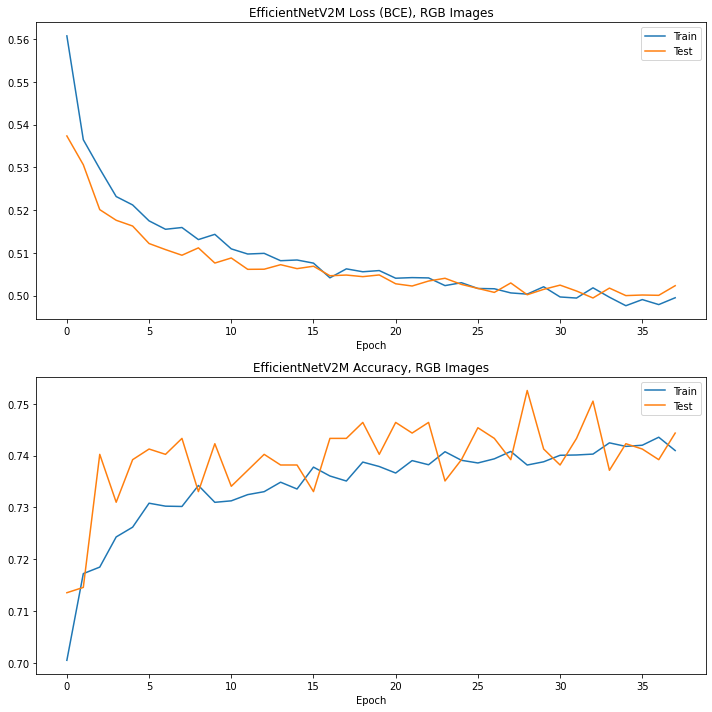

In [ ]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(2,1,1)
ax1.plot(res.history['loss'], label = 'Train')
ax1.plot(res.history['val_loss'], label = 'Test')
plt.title('EfficientNetV2M Loss (BCE), RGB Images')
plt.xlabel('Epoch')
plt.legend();

ax2 = plt.subplot(2,1,2)
ax2.plot(res.history['acc'], label = 'Train')
ax2.plot(res.history['val_acc'], label = 'Test')
plt.title('EfficientNetV2M Accuracy, RGB Images')
plt.xlabel('Epoch')
plt.legend();
plt.tight_layout();
plt.savefig('../presentation_images/effnet_RGB')

So `EfficientNetV2M`, when trained on the RGB images only, did noticeably better than our custom-built network.  It achieved an accuracy score of over 74%.

Thus, going forward, we will use `EfficientNetV2M` instead of trying to build our own CNN architecture.

#### Test that the model saved correctly

Before proceeding, let's make sure we can load the saved model and use it for predictions in the future:

In [ ]:
rgb_model = load_model(f"{model_save_path}/rgb_classification_effnet_1")

In [ ]:
rgb_model.evaluate(rgb_test_ds)

31/31 [==============================] - 24s 450ms/step - loss: 0.5023 - acc: 0.7444


[0.502298891544342, 0.744353175163269]

These are the same loss and accuracy numbers that we got before, so everything is working!

## Using a pre-trained network on NIR data

In [ ]:
effnet_nir = EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_shape=(255,255,3),
    classes=2,
    classifier_activation="softmax",
    include_preprocessing=True,
)

In [ ]:
effnet_nir.trainable = False

In [ ]:
model = Sequential()

model.add(effnet_nir)
model.add(GlobalAveragePooling2D())

#Just use a single output layer
model.add(Dense(1, activation='sigmoid'))


#Compile the model
model.compile(optimizer='adam',
              loss='bce',
              metrics=['acc'])

In [ ]:
model_name = 'NIR_classification_effnet_1'
model_save_path = '../models'

In [ ]:
#Add a callback to save the model each epoch
checkpoint = ModelCheckpoint(f"{model_save_path}/{model_name}", save_freq='epoch', verbose=0)

In [ ]:
#Add early stopping
es = EarlyStopping( patience = 5)

In [ ]:
res = model.fit(NIR_train_ds,
                epochs = 50,
                validation_data = NIR_test_ds,
                verbose = 1,
                callbacks = [es, checkpoint]
                )

Epoch 1/50
547/548 [============================>.] - ETA: 0s - loss: 0.5771 - acc: 0.6864

548/548 [==============================] - 574s 1s/step - loss: 0.5770 - acc: 0.6865 - val_loss: 0.5749 - val_acc: 0.6858
Epoch 2/50
547/548 [============================>.] - ETA: 0s - loss: 0.5590 - acc: 0.6977

548/548 [==============================] - 175s 319ms/step - loss: 0.5589 - acc: 0.6977 - val_loss: 0.5789 - val_acc: 0.6858
Epoch 3/50
547/548 [============================>.] - ETA: 0s - loss: 0.5536 - acc: 0.7041

548/548 [==============================] - 174s 318ms/step - loss: 0.5537 - acc: 0.7041 - val_loss: 0.5677 - val_acc: 0.6930
Epoch 4/50
547/548 [============================>.] - ETA: 0s - loss: 0.5502 - acc: 0.7048

548/548 [==============================] - 197s 360ms/step - loss: 0.5502 - acc: 0.7047 - val_loss: 0.5709 - val_acc: 0.6889
Epoch 5/50
547/548 [============================>.] - ETA: 0s - loss: 0.5478 - acc: 0.7087

548/548 [==============================] - 174s 317ms/step - loss: 0.5478 - acc: 0.7087 - val_loss: 0.5645 - val_acc: 0.6899
Epoch 6/50
547/548 [============================>.] - ETA: 0s - loss: 0.5439 - acc: 0.7114

548/548 [==============================] - 197s 359ms/step - loss: 0.5439 - acc: 0.7115 - val_loss: 0.5610 - val_acc: 0.7012
Epoch 7/50
547/548 [============================>.] - ETA: 0s - loss: 0.5432 - acc: 0.7096

548/548 [==============================] - 175s 320ms/step - loss: 0.5430 - acc: 0.7097 - val_loss: 0.5621 - val_acc: 0.7023
Epoch 8/50
547/548 [============================>.] - ETA: 0s - loss: 0.5408 - acc: 0.7125

548/548 [==============================] - 174s 318ms/step - loss: 0.5408 - acc: 0.7123 - val_loss: 0.5647 - val_acc: 0.6910
Epoch 9/50
547/548 [============================>.] - ETA: 0s - loss: 0.5390 - acc: 0.7150

548/548 [==============================] - 199s 363ms/step - loss: 0.5390 - acc: 0.7151 - val_loss: 0.5623 - val_acc: 0.6920
Epoch 10/50
547/548 [============================>.] - ETA: 0s - loss: 0.5394 - acc: 0.7158

548/548 [==============================] - 177s 323ms/step - loss: 0.5393 - acc: 0.7159 - val_loss: 0.5610 - val_acc: 0.6992
Epoch 11/50
547/548 [============================>.] - ETA: 0s - loss: 0.5388 - acc: 0.7140

548/548 [==============================] - 175s 319ms/step - loss: 0.5386 - acc: 0.7142 - val_loss: 0.5688 - val_acc: 0.7002
Epoch 12/50
547/548 [============================>.] - ETA: 0s - loss: 0.5362 - acc: 0.7214

548/548 [==============================] - 201s 367ms/step - loss: 0.5361 - acc: 0.7215 - val_loss: 0.5611 - val_acc: 0.6899
Epoch 13/50
547/548 [============================>.] - ETA: 0s - loss: 0.5360 - acc: 0.7158

548/548 [==============================] - 177s 322ms/step - loss: 0.5359 - acc: 0.7160 - val_loss: 0.5614 - val_acc: 0.6848
Epoch 14/50
547/548 [============================>.] - ETA: 0s - loss: 0.5351 - acc: 0.7185

548/548 [==============================] - 175s 320ms/step - loss: 0.5350 - acc: 0.7184 - val_loss: 0.5601 - val_acc: 0.6899
Epoch 15/50
547/548 [============================>.] - ETA: 0s - loss: 0.5330 - acc: 0.7174

548/548 [==============================] - 202s 369ms/step - loss: 0.5329 - acc: 0.7176 - val_loss: 0.5640 - val_acc: 0.6889
Epoch 16/50
547/548 [============================>.] - ETA: 0s - loss: 0.5357 - acc: 0.7189

548/548 [==============================] - 176s 321ms/step - loss: 0.5357 - acc: 0.7188 - val_loss: 0.5642 - val_acc: 0.6879
Epoch 17/50
547/548 [============================>.] - ETA: 0s - loss: 0.5339 - acc: 0.7199

548/548 [==============================] - 174s 318ms/step - loss: 0.5337 - acc: 0.7201 - val_loss: 0.5658 - val_acc: 0.6869
Epoch 18/50
547/548 [============================>.] - ETA: 0s - loss: 0.5305 - acc: 0.7191

548/548 [==============================] - 173s 317ms/step - loss: 0.5307 - acc: 0.7190 - val_loss: 0.5606 - val_acc: 0.6858
Epoch 19/50
547/548 [============================>.] - ETA: 0s - loss: 0.5321 - acc: 0.7230

548/548 [==============================] - 204s 372ms/step - loss: 0.5320 - acc: 0.7229 - val_loss: 0.5622 - val_acc: 0.6899


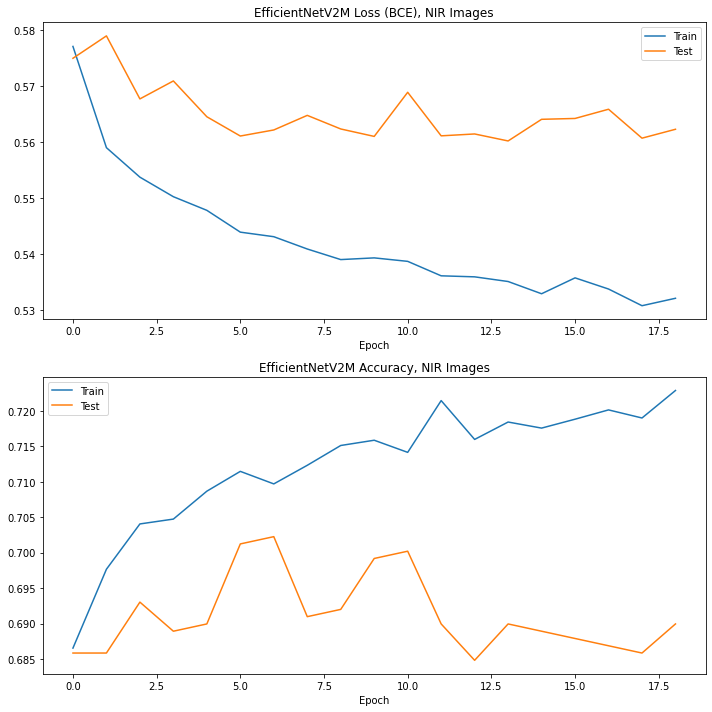

In [ ]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(2,1,1)
ax1.plot(res.history['loss'], label = 'Train')
ax1.plot(res.history['val_loss'], label = 'Test')
plt.title('EfficientNetV2M Loss (BCE), NIR Images')
plt.xlabel('Epoch')
plt.legend();

ax2 = plt.subplot(2,1,2)
ax2.plot(res.history['acc'], label = 'Train')
ax2.plot(res.history['val_acc'], label = 'Test')
plt.title('EfficientNetV2M Accuracy, NIR Images')
plt.xlabel('Epoch')
plt.legend();
plt.tight_layout();
plt.savefig('../presentation_images/effnet_NIR')

This model did not do so well.

#### Test that the model saved correctly

Before proceeding, let's make sure we can load the saved model and use it for predictions in the future:

In [ ]:
NIR_model = load_model(f"{model_save_path}/NIR_classification_effnet_1")

In [ ]:
NIR_model.evaluate(NIR_test_ds)

31/31 [==============================] - 6s 64ms/step - loss: 0.5622 - acc: 0.6899


[0.5622337460517883, 0.6899384260177612]

These are the same loss and accuracy numbers that we got before, so everything is working!

## Using a pre-trained network on SWIR1 data

In [ ]:
effnet_ir = EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_shape=(255,255,3),
    classes=2,
    classifier_activation="softmax",
    include_preprocessing=True,
)

In [ ]:
effnet_ir.trainable = False

In [ ]:
model = Sequential()

model.add(effnet_ir)
model.add(GlobalAveragePooling2D())

#Just use a single output layer
model.add(Dense(1, activation='sigmoid'))


#Compile the model
model.compile(optimizer='adam',
              loss='bce',
              metrics=['acc'])

In [ ]:
model_name = 'SWIR1_classification_effnet_1'
model_save_path = '../models'

In [ ]:
#Add a callback to save the model each epoch
checkpoint = ModelCheckpoint(f"{model_save_path}/{model_name}", save_freq='epoch', verbose=0)

In [ ]:
#Add early stopping
es = EarlyStopping( patience = 5)

In [ ]:
res = model.fit(SWIR1_train_ds,
                epochs = 50,
                validation_data = SWIR1_test_ds,
                verbose = 1,
                callbacks = [es, checkpoint]
                )

Epoch 1/50
548/548 [==============================] - ETA: 0s - loss: 0.5785 - acc: 0.6884

548/548 [==============================] - 540s 947ms/step - loss: 0.5785 - acc: 0.6884 - val_loss: 0.5690 - val_acc: 0.6920
Epoch 2/50
547/548 [============================>.] - ETA: 0s - loss: 0.5567 - acc: 0.7021

548/548 [==============================] - 185s 337ms/step - loss: 0.5568 - acc: 0.7021 - val_loss: 0.5653 - val_acc: 0.6951
Epoch 3/50
547/548 [============================>.] - ETA: 0s - loss: 0.5500 - acc: 0.7049

548/548 [==============================] - 174s 317ms/step - loss: 0.5501 - acc: 0.7049 - val_loss: 0.5522 - val_acc: 0.6992
Epoch 4/50
547/548 [============================>.] - ETA: 0s - loss: 0.5449 - acc: 0.7095

548/548 [==============================] - 187s 341ms/step - loss: 0.5448 - acc: 0.7096 - val_loss: 0.5531 - val_acc: 0.6992
Epoch 5/50
547/548 [============================>.] - ETA: 0s - loss: 0.5418 - acc: 0.7128

548/548 [==============================] - 186s 339ms/step - loss: 0.5417 - acc: 0.7128 - val_loss: 0.5463 - val_acc: 0.7084
Epoch 6/50
547/548 [============================>.] - ETA: 0s - loss: 0.5395 - acc: 0.7137

548/548 [==============================] - 173s 316ms/step - loss: 0.5395 - acc: 0.7136 - val_loss: 0.5435 - val_acc: 0.7197
Epoch 7/50
547/548 [============================>.] - ETA: 0s - loss: 0.5377 - acc: 0.7161

548/548 [==============================] - 188s 343ms/step - loss: 0.5376 - acc: 0.7162 - val_loss: 0.5444 - val_acc: 0.7084
Epoch 8/50
547/548 [============================>.] - ETA: 0s - loss: 0.5367 - acc: 0.7149

548/548 [==============================] - 173s 316ms/step - loss: 0.5368 - acc: 0.7148 - val_loss: 0.5431 - val_acc: 0.7115
Epoch 9/50
547/548 [============================>.] - ETA: 0s - loss: 0.5336 - acc: 0.7193

548/548 [==============================] - 188s 344ms/step - loss: 0.5336 - acc: 0.7192 - val_loss: 0.5458 - val_acc: 0.7012
Epoch 10/50
547/548 [============================>.] - ETA: 0s - loss: 0.5333 - acc: 0.7177

548/548 [==============================] - 173s 316ms/step - loss: 0.5332 - acc: 0.7177 - val_loss: 0.5375 - val_acc: 0.7064
Epoch 11/50
548/548 [==============================] - ETA: 0s - loss: 0.5309 - acc: 0.7203

548/548 [==============================] - 188s 344ms/step - loss: 0.5309 - acc: 0.7203 - val_loss: 0.5471 - val_acc: 0.6971
Epoch 12/50
547/548 [============================>.] - ETA: 0s - loss: 0.5308 - acc: 0.7205

548/548 [==============================] - 187s 341ms/step - loss: 0.5307 - acc: 0.7205 - val_loss: 0.5385 - val_acc: 0.7177
Epoch 13/50
548/548 [==============================] - ETA: 0s - loss: 0.5295 - acc: 0.7237

548/548 [==============================] - 174s 318ms/step - loss: 0.5295 - acc: 0.7237 - val_loss: 0.5421 - val_acc: 0.7094
Epoch 14/50
547/548 [============================>.] - ETA: 0s - loss: 0.5294 - acc: 0.7212

548/548 [==============================] - 190s 346ms/step - loss: 0.5293 - acc: 0.7212 - val_loss: 0.5391 - val_acc: 0.7187
Epoch 15/50
547/548 [============================>.] - ETA: 0s - loss: 0.5292 - acc: 0.7229

548/548 [==============================] - 174s 318ms/step - loss: 0.5290 - acc: 0.7230 - val_loss: 0.5391 - val_acc: 0.7125


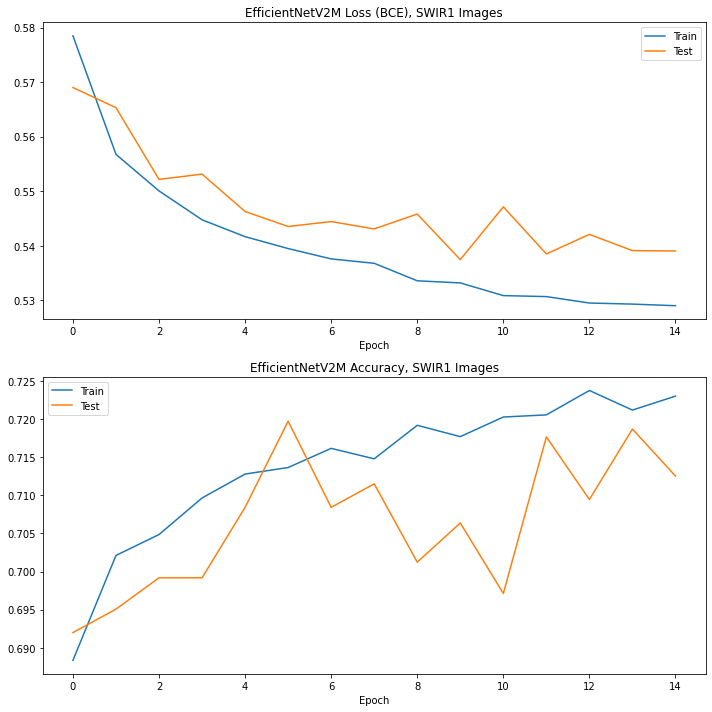

In [ ]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(2,1,1)
ax1.plot(res.history['loss'], label = 'Train')
ax1.plot(res.history['val_loss'], label = 'Test')
plt.title('EfficientNetV2M Loss (BCE), SWIR1 Images')
plt.xlabel('Epoch')
plt.legend();

ax2 = plt.subplot(2,1,2)
ax2.plot(res.history['acc'], label = 'Train')
ax2.plot(res.history['val_acc'], label = 'Test')
plt.title('EfficientNetV2M Accuracy, SWIR1 Images')
plt.xlabel('Epoch')
plt.legend();
plt.tight_layout();
plt.savefig('../presentation_images/effnet_SWIR1')

This model did not do as well as the RGB model!

#### Test that the model saved correctly

Before proceeding, let's make sure we can load the saved model and use it for predictions in the future:

In [ ]:
SWIR1_model = load_model(f"{model_save_path}/SWIR1_classification_effnet_1")

In [ ]:
SWIR1_model.evaluate(SWIR1_test_ds)

31/31 [==============================] - 2s 64ms/step - loss: 0.5391 - acc: 0.7125


[0.5390536785125732, 0.7125256657600403]

These are the same loss and accuracy numbers that we got before, so everything is working!

## Using a pre-trained network on SWIR2 data

In [ ]:
effnet_ir2 = EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_shape=(255,255,3),
    classes=2,
    classifier_activation="softmax",
    include_preprocessing=True,
)

In [ ]:
effnet_ir2.trainable = False

In [ ]:
model = Sequential()

model.add(effnet_ir2)
model.add(GlobalAveragePooling2D())

#Just use a single output layer
model.add(Dense(1, activation='sigmoid'))


#Compile the model
model.compile(optimizer='adam',
              loss='bce',
              metrics=['acc'])

In [ ]:
model_name = 'SWIR2_classification_effnet_1'
model_save_path = '../models'

In [ ]:
#Add a callback to save the model each epoch
checkpoint = ModelCheckpoint(f"{model_save_path}/{model_name}", save_freq='epoch', verbose=0)

In [ ]:
#Add early stopping
es = EarlyStopping( patience = 5)

In [ ]:
res = model.fit(SWIR2_train_ds,
                epochs = 50,
                validation_data = SWIR2_test_ds,
                verbose = 1,
                callbacks = [es, checkpoint]
                )

Epoch 1/50
547/548 [============================>.] - ETA: 0s - loss: 0.5825 - acc: 0.6847

548/548 [==============================] - 543s 951ms/step - loss: 0.5824 - acc: 0.6847 - val_loss: 0.5850 - val_acc: 0.6848
Epoch 2/50
547/548 [============================>.] - ETA: 0s - loss: 0.5596 - acc: 0.7019

548/548 [==============================] - 204s 373ms/step - loss: 0.5596 - acc: 0.7018 - val_loss: 0.5813 - val_acc: 0.6858
Epoch 3/50
547/548 [============================>.] - ETA: 0s - loss: 0.5520 - acc: 0.7076

548/548 [==============================] - 179s 326ms/step - loss: 0.5520 - acc: 0.7075 - val_loss: 0.5687 - val_acc: 0.6797
Epoch 4/50
548/548 [==============================] - ETA: 0s - loss: 0.5496 - acc: 0.7100

548/548 [==============================] - 177s 323ms/step - loss: 0.5496 - acc: 0.7100 - val_loss: 0.5711 - val_acc: 0.6940
Epoch 5/50
547/548 [============================>.] - ETA: 0s - loss: 0.5454 - acc: 0.7118

548/548 [==============================] - 176s 321ms/step - loss: 0.5453 - acc: 0.7118 - val_loss: 0.5635 - val_acc: 0.6879
Epoch 6/50
547/548 [============================>.] - ETA: 0s - loss: 0.5417 - acc: 0.7141

548/548 [==============================] - 205s 375ms/step - loss: 0.5417 - acc: 0.7140 - val_loss: 0.5614 - val_acc: 0.6848
Epoch 7/50
547/548 [============================>.] - ETA: 0s - loss: 0.5402 - acc: 0.7152

548/548 [==============================] - 175s 319ms/step - loss: 0.5402 - acc: 0.7152 - val_loss: 0.5573 - val_acc: 0.6940
Epoch 8/50
547/548 [============================>.] - ETA: 0s - loss: 0.5389 - acc: 0.7132

548/548 [==============================] - 173s 317ms/step - loss: 0.5390 - acc: 0.7130 - val_loss: 0.5589 - val_acc: 0.6992
Epoch 9/50
547/548 [============================>.] - ETA: 0s - loss: 0.5398 - acc: 0.7182

548/548 [==============================] - 207s 378ms/step - loss: 0.5398 - acc: 0.7183 - val_loss: 0.5626 - val_acc: 0.6951
Epoch 10/50
547/548 [============================>.] - ETA: 0s - loss: 0.5360 - acc: 0.7186

548/548 [==============================] - 177s 323ms/step - loss: 0.5360 - acc: 0.7187 - val_loss: 0.5555 - val_acc: 0.6910
Epoch 11/50
547/548 [============================>.] - ETA: 0s - loss: 0.5357 - acc: 0.7187

548/548 [==============================] - 177s 323ms/step - loss: 0.5357 - acc: 0.7188 - val_loss: 0.5625 - val_acc: 0.6971
Epoch 12/50
547/548 [============================>.] - ETA: 0s - loss: 0.5339 - acc: 0.7209

548/548 [==============================] - 178s 325ms/step - loss: 0.5338 - acc: 0.7211 - val_loss: 0.5559 - val_acc: 0.6899
Epoch 13/50
547/548 [============================>.] - ETA: 0s - loss: 0.5335 - acc: 0.7193

548/548 [==============================] - 212s 387ms/step - loss: 0.5334 - acc: 0.7194 - val_loss: 0.5634 - val_acc: 0.6920
Epoch 14/50
547/548 [============================>.] - ETA: 0s - loss: 0.5319 - acc: 0.7203

548/548 [==============================] - 179s 327ms/step - loss: 0.5319 - acc: 0.7203 - val_loss: 0.5542 - val_acc: 0.6971
Epoch 15/50
547/548 [============================>.] - ETA: 0s - loss: 0.5314 - acc: 0.7217

548/548 [==============================] - 179s 326ms/step - loss: 0.5313 - acc: 0.7219 - val_loss: 0.5551 - val_acc: 0.6940
Epoch 16/50
548/548 [==============================] - ETA: 0s - loss: 0.5275 - acc: 0.7267

548/548 [==============================] - 210s 383ms/step - loss: 0.5275 - acc: 0.7267 - val_loss: 0.5544 - val_acc: 0.6930
Epoch 17/50
547/548 [============================>.] - ETA: 0s - loss: 0.5307 - acc: 0.7219

548/548 [==============================] - 180s 329ms/step - loss: 0.5305 - acc: 0.7221 - val_loss: 0.5540 - val_acc: 0.6982
Epoch 18/50
547/548 [============================>.] - ETA: 0s - loss: 0.5298 - acc: 0.7238

548/548 [==============================] - 179s 327ms/step - loss: 0.5300 - acc: 0.7237 - val_loss: 0.5545 - val_acc: 0.6961
Epoch 19/50
547/548 [============================>.] - ETA: 0s - loss: 0.5280 - acc: 0.7262

548/548 [==============================] - 179s 326ms/step - loss: 0.5279 - acc: 0.7263 - val_loss: 0.5589 - val_acc: 0.6961
Epoch 20/50
547/548 [============================>.] - ETA: 0s - loss: 0.5267 - acc: 0.7239

548/548 [==============================] - 213s 389ms/step - loss: 0.5266 - acc: 0.7239 - val_loss: 0.5521 - val_acc: 0.6951
Epoch 21/50
547/548 [============================>.] - ETA: 0s - loss: 0.5280 - acc: 0.7257

548/548 [==============================] - 178s 324ms/step - loss: 0.5277 - acc: 0.7259 - val_loss: 0.5527 - val_acc: 0.6920
Epoch 22/50
547/548 [============================>.] - ETA: 0s - loss: 0.5270 - acc: 0.7242

548/548 [==============================] - 175s 320ms/step - loss: 0.5269 - acc: 0.7242 - val_loss: 0.5542 - val_acc: 0.6951
Epoch 23/50
547/548 [============================>.] - ETA: 0s - loss: 0.5258 - acc: 0.7249

548/548 [==============================] - 175s 320ms/step - loss: 0.5257 - acc: 0.7251 - val_loss: 0.5480 - val_acc: 0.7023
Epoch 24/50
547/548 [============================>.] - ETA: 0s - loss: 0.5256 - acc: 0.7268

548/548 [==============================] - 211s 386ms/step - loss: 0.5255 - acc: 0.7269 - val_loss: 0.5581 - val_acc: 0.6982
Epoch 25/50
547/548 [============================>.] - ETA: 0s - loss: 0.5230 - acc: 0.7294

548/548 [==============================] - 178s 326ms/step - loss: 0.5231 - acc: 0.7292 - val_loss: 0.5487 - val_acc: 0.7002
Epoch 26/50
547/548 [============================>.] - ETA: 0s - loss: 0.5233 - acc: 0.7287

548/548 [==============================] - 178s 325ms/step - loss: 0.5232 - acc: 0.7288 - val_loss: 0.5461 - val_acc: 0.7002
Epoch 27/50
547/548 [============================>.] - ETA: 0s - loss: 0.5225 - acc: 0.7304

548/548 [==============================] - 175s 319ms/step - loss: 0.5226 - acc: 0.7303 - val_loss: 0.5456 - val_acc: 0.7074
Epoch 28/50
547/548 [============================>.] - ETA: 0s - loss: 0.5240 - acc: 0.7293

548/548 [==============================] - 177s 323ms/step - loss: 0.5240 - acc: 0.7293 - val_loss: 0.5478 - val_acc: 0.7002
Epoch 29/50
547/548 [============================>.] - ETA: 0s - loss: 0.5244 - acc: 0.7274

548/548 [==============================] - 214s 390ms/step - loss: 0.5243 - acc: 0.7275 - val_loss: 0.5498 - val_acc: 0.6982
Epoch 30/50
547/548 [============================>.] - ETA: 0s - loss: 0.5218 - acc: 0.7282

548/548 [==============================] - 177s 324ms/step - loss: 0.5217 - acc: 0.7284 - val_loss: 0.5498 - val_acc: 0.6992
Epoch 31/50
547/548 [============================>.] - ETA: 0s - loss: 0.5226 - acc: 0.7273

548/548 [==============================] - 176s 322ms/step - loss: 0.5227 - acc: 0.7273 - val_loss: 0.5509 - val_acc: 0.6982
Epoch 32/50
547/548 [============================>.] - ETA: 0s - loss: 0.5225 - acc: 0.7308

548/548 [==============================] - 175s 320ms/step - loss: 0.5225 - acc: 0.7308 - val_loss: 0.5456 - val_acc: 0.7064


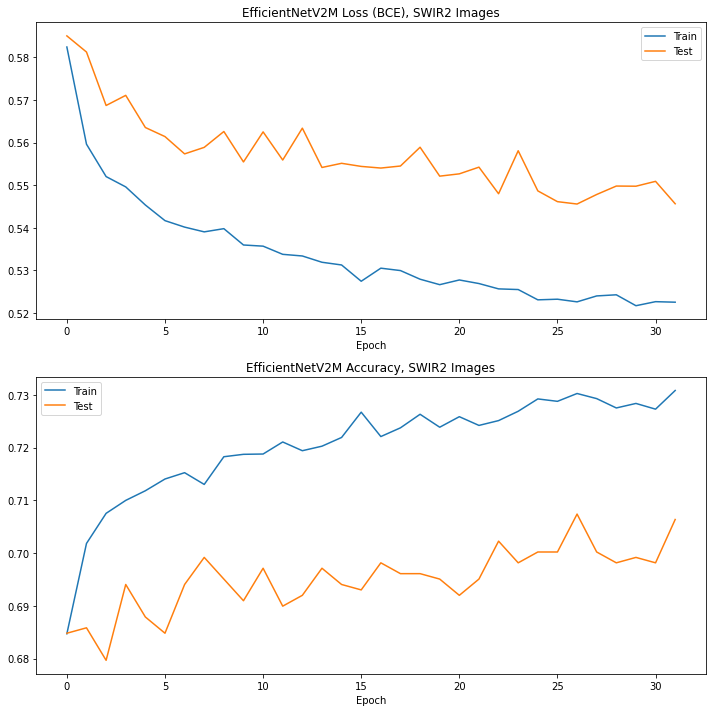

In [ ]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(2,1,1)
ax1.plot(res.history['loss'], label = 'Train')
ax1.plot(res.history['val_loss'], label = 'Test')
plt.title('EfficientNetV2M Loss (BCE), SWIR2 Images')
plt.xlabel('Epoch')
plt.legend();

ax2 = plt.subplot(2,1,2)
ax2.plot(res.history['acc'], label = 'Train')
ax2.plot(res.history['val_acc'], label = 'Test')
plt.title('EfficientNetV2M Accuracy, SWIR2 Images')
plt.xlabel('Epoch')
plt.legend();
plt.tight_layout();
plt.savefig('../presentation_images/effnet_SWIR2')

This model performed somewhat poorly as well.

#### Test that the model saved correctly

Before proceeding, let's make sure we can load the saved model and use it for predictions in the future:

In [ ]:
SWIR2_model = load_model(f"{model_save_path}/SWIR2_classification_effnet_1")

In [ ]:
SWIR2_model.evaluate(SWIR2_test_ds)

31/31 [==============================] - 7s 64ms/step - loss: 0.5456 - acc: 0.7064


[0.5456404089927673, 0.7063655257225037]

These are the same loss and accuracy numbers that we got before, so everything is working!

## Using a pre-trained network on TEMP1 data

In [ ]:
effnet_temp = EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_shape=(255,255,3),
    classes=2,
    classifier_activation="softmax",
    include_preprocessing=True,
)

In [ ]:
effnet_temp.trainable = False

In [ ]:
model = Sequential()

model.add(effnet_temp)
model.add(GlobalAveragePooling2D())

#Just use a single output layer
model.add(Dense(1, activation='sigmoid'))


#Compile the model
model.compile(optimizer='adam',
              loss='bce',
              metrics=['acc'])

In [ ]:
model_name = 'TEMP1_classification_effnet_1'
model_save_path = '../models'

In [ ]:
#Add a callback to save the model each epoch
checkpoint = ModelCheckpoint(f"{model_save_path}/{model_name}", save_freq='epoch', verbose=0)

In [ ]:
#Add early stopping
es = EarlyStopping( patience = 5)

In [ ]:
res = model.fit(TEMP1_train_ds,
                epochs = 50,
                validation_data = TEMP1_test_ds,
                verbose = 1,
                callbacks = [es, checkpoint]
                )

Epoch 1/50
547/548 [============================>.] - ETA: 0s - loss: 0.6044 - acc: 0.6806

548/548 [==============================] - 514s 897ms/step - loss: 0.6045 - acc: 0.6806 - val_loss: 0.5903 - val_acc: 0.6817
Epoch 2/50
547/548 [============================>.] - ETA: 0s - loss: 0.5913 - acc: 0.6899

548/548 [==============================] - 189s 346ms/step - loss: 0.5913 - acc: 0.6899 - val_loss: 0.5857 - val_acc: 0.6858
Epoch 3/50
547/548 [============================>.] - ETA: 0s - loss: 0.5838 - acc: 0.6917

548/548 [==============================] - 176s 321ms/step - loss: 0.5837 - acc: 0.6916 - val_loss: 0.5758 - val_acc: 0.6940
Epoch 4/50
547/548 [============================>.] - ETA: 0s - loss: 0.5829 - acc: 0.6947

548/548 [==============================] - 174s 317ms/step - loss: 0.5828 - acc: 0.6948 - val_loss: 0.5816 - val_acc: 0.6889
Epoch 5/50
547/548 [============================>.] - ETA: 0s - loss: 0.5805 - acc: 0.6952

548/548 [==============================] - 192s 351ms/step - loss: 0.5805 - acc: 0.6953 - val_loss: 0.5724 - val_acc: 0.6982
Epoch 6/50
547/548 [============================>.] - ETA: 0s - loss: 0.5779 - acc: 0.6954

548/548 [==============================] - 173s 317ms/step - loss: 0.5780 - acc: 0.6953 - val_loss: 0.5727 - val_acc: 0.6920
Epoch 7/50
547/548 [============================>.] - ETA: 0s - loss: 0.5771 - acc: 0.6962

548/548 [==============================] - 193s 352ms/step - loss: 0.5772 - acc: 0.6961 - val_loss: 0.5717 - val_acc: 0.6961
Epoch 8/50
547/548 [============================>.] - ETA: 0s - loss: 0.5762 - acc: 0.6986

548/548 [==============================] - 174s 317ms/step - loss: 0.5762 - acc: 0.6986 - val_loss: 0.5715 - val_acc: 0.6951
Epoch 9/50
547/548 [============================>.] - ETA: 0s - loss: 0.5724 - acc: 0.7016

548/548 [==============================] - 194s 355ms/step - loss: 0.5725 - acc: 0.7016 - val_loss: 0.5703 - val_acc: 0.6951
Epoch 10/50
547/548 [============================>.] - ETA: 0s - loss: 0.5728 - acc: 0.7004

548/548 [==============================] - 176s 322ms/step - loss: 0.5728 - acc: 0.7004 - val_loss: 0.5695 - val_acc: 0.6951
Epoch 11/50
547/548 [============================>.] - ETA: 0s - loss: 0.5714 - acc: 0.7012

548/548 [==============================] - 195s 356ms/step - loss: 0.5714 - acc: 0.7011 - val_loss: 0.5791 - val_acc: 0.6899
Epoch 12/50
547/548 [============================>.] - ETA: 0s - loss: 0.5692 - acc: 0.7026

548/548 [==============================] - 177s 323ms/step - loss: 0.5692 - acc: 0.7026 - val_loss: 0.5662 - val_acc: 0.6940
Epoch 13/50
547/548 [============================>.] - ETA: 0s - loss: 0.5713 - acc: 0.7012

548/548 [==============================] - 176s 322ms/step - loss: 0.5712 - acc: 0.7013 - val_loss: 0.5727 - val_acc: 0.6889
Epoch 14/50
547/548 [============================>.] - ETA: 0s - loss: 0.5688 - acc: 0.7018

548/548 [==============================] - 198s 362ms/step - loss: 0.5688 - acc: 0.7017 - val_loss: 0.5673 - val_acc: 0.6940
Epoch 15/50
547/548 [============================>.] - ETA: 0s - loss: 0.5686 - acc: 0.6997

548/548 [==============================] - 177s 322ms/step - loss: 0.5684 - acc: 0.6999 - val_loss: 0.5680 - val_acc: 0.6951
Epoch 16/50
547/548 [============================>.] - ETA: 0s - loss: 0.5690 - acc: 0.7018

548/548 [==============================] - 198s 361ms/step - loss: 0.5690 - acc: 0.7018 - val_loss: 0.5684 - val_acc: 0.6930
Epoch 17/50
547/548 [============================>.] - ETA: 0s - loss: 0.5681 - acc: 0.7043

548/548 [==============================] - 176s 322ms/step - loss: 0.5679 - acc: 0.7045 - val_loss: 0.5697 - val_acc: 0.6961


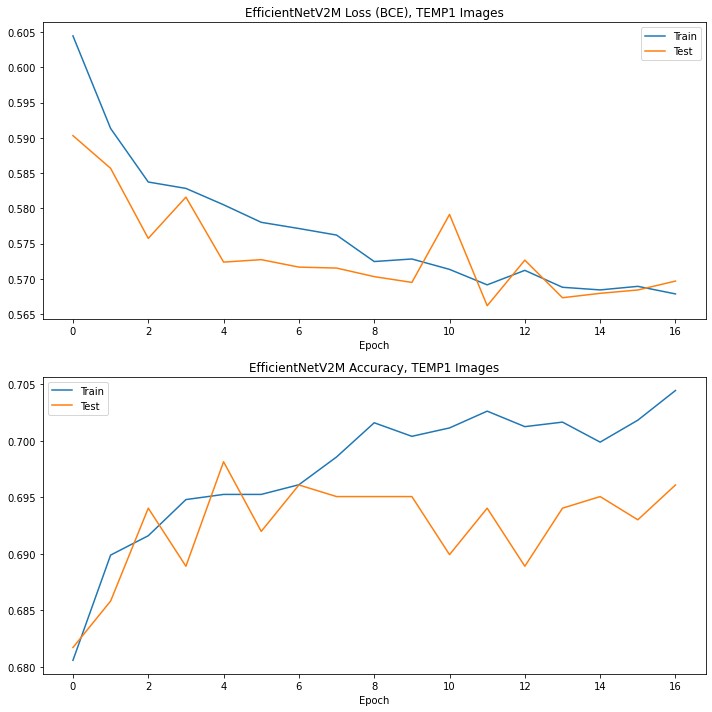

In [ ]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(2,1,1)
ax1.plot(res.history['loss'], label = 'Train')
ax1.plot(res.history['val_loss'], label = 'Test')
plt.title('EfficientNetV2M Loss (BCE), TEMP1 Images')
plt.xlabel('Epoch')
plt.legend();

ax2 = plt.subplot(2,1,2)
ax2.plot(res.history['acc'], label = 'Train')
ax2.plot(res.history['val_acc'], label = 'Test')
plt.title('EfficientNetV2M Accuracy, TEMP1 Images')
plt.xlabel('Epoch')
plt.legend();
plt.tight_layout();
plt.savefig('../presentation_images/effnet_TEMP1')

This model did rather poorly.

#### Test that the model saved correctly

Before proceeding, let's make sure we can load the saved model and use it for predictions in the future:

In [ ]:
TEMP1_model = load_model(f"{model_save_path}/TEMP1_classification_effnet_1")

In [ ]:
TEMP1_model.evaluate(TEMP1_test_ds)

31/31 [==============================] - 2s 65ms/step - loss: 0.5697 - acc: 0.6961


[0.5696952939033508, 0.6960985660552979]

These are the same loss and accuracy numbers that we got before, so everything is working!

## Using a pre-trained network on NIGHTLIGHTS data

In [ ]:
#32 x 32 is the minimum image size - we will need to inflate the images back to 32x32 in our model
effnet_nl = EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_shape=(32,32,3),
    classes=2,
    classifier_activation="softmax",
    include_preprocessing=True,
)

214201816/214201816 [==============================] - 1s 0us/step


In [ ]:
effnet_nl.trainable = False

In [ ]:
model = Sequential()

#Upscale 8x8 images to 32x32 for the effnet_nl
model.add(Resizing(32,32))

model.add(effnet_nl)
model.add(GlobalAveragePooling2D())

#Just use a single output layer
model.add(Dense(1, activation='sigmoid'))


#Compile the model
model.compile(optimizer='adam',
              loss='bce',
              metrics=['acc'])

In [ ]:
model_name = 'nightlights_classification_effnet_1'
model_save_path = '../models'

In [ ]:
#Add a callback to save the model each epoch
checkpoint = ModelCheckpoint(f"{model_save_path}/{model_name}", save_freq='epoch', verbose=0)

In [ ]:
#Add early stopping
es = EarlyStopping( patience = 5)

In [ ]:
res = model.fit(nl_train_ds,
                epochs = 50,
                validation_data = nl_test_ds,
                verbose = 1,
                callbacks = [es, checkpoint]
                )

Epoch 1/50
548/548 [==============================] - ETA: 0s - loss: 0.5782 - acc: 0.7067

548/548 [==============================] - 535s 918ms/step - loss: 0.5782 - acc: 0.7067 - val_loss: 0.5357 - val_acc: 0.7505
Epoch 2/50
547/548 [============================>.] - ETA: 0s - loss: 0.5416 - acc: 0.7343

548/548 [==============================] - 165s 302ms/step - loss: 0.5415 - acc: 0.7342 - val_loss: 0.5212 - val_acc: 0.7495
Epoch 3/50
548/548 [==============================] - ETA: 0s - loss: 0.5288 - acc: 0.7422

548/548 [==============================] - 166s 303ms/step - loss: 0.5288 - acc: 0.7422 - val_loss: 0.5117 - val_acc: 0.7392
Epoch 4/50
547/548 [============================>.] - ETA: 0s - loss: 0.5248 - acc: 0.7462

548/548 [==============================] - 168s 307ms/step - loss: 0.5246 - acc: 0.7462 - val_loss: 0.5096 - val_acc: 0.7526
Epoch 5/50
547/548 [============================>.] - ETA: 0s - loss: 0.5200 - acc: 0.7457

548/548 [==============================] - 167s 305ms/step - loss: 0.5200 - acc: 0.7457 - val_loss: 0.5045 - val_acc: 0.7413
Epoch 6/50
548/548 [==============================] - ETA: 0s - loss: 0.5152 - acc: 0.7486

548/548 [==============================] - 167s 306ms/step - loss: 0.5152 - acc: 0.7486 - val_loss: 0.5028 - val_acc: 0.7331
Epoch 7/50
548/548 [==============================] - ETA: 0s - loss: 0.5160 - acc: 0.7455

548/548 [==============================] - 168s 308ms/step - loss: 0.5160 - acc: 0.7455 - val_loss: 0.5012 - val_acc: 0.7413
Epoch 8/50
547/548 [============================>.] - ETA: 0s - loss: 0.5135 - acc: 0.7491

548/548 [==============================] - 169s 308ms/step - loss: 0.5135 - acc: 0.7490 - val_loss: 0.5020 - val_acc: 0.7444
Epoch 9/50
547/548 [============================>.] - ETA: 0s - loss: 0.5115 - acc: 0.7485

548/548 [==============================] - 167s 305ms/step - loss: 0.5115 - acc: 0.7485 - val_loss: 0.5041 - val_acc: 0.7474
Epoch 10/50
548/548 [==============================] - ETA: 0s - loss: 0.5107 - acc: 0.7488

548/548 [==============================] - 169s 308ms/step - loss: 0.5107 - acc: 0.7488 - val_loss: 0.4979 - val_acc: 0.7392
Epoch 11/50
548/548 [==============================] - ETA: 0s - loss: 0.5087 - acc: 0.7514

548/548 [==============================] - 168s 307ms/step - loss: 0.5087 - acc: 0.7514 - val_loss: 0.5048 - val_acc: 0.7474
Epoch 12/50
547/548 [============================>.] - ETA: 0s - loss: 0.5083 - acc: 0.7511

548/548 [==============================] - 171s 312ms/step - loss: 0.5081 - acc: 0.7513 - val_loss: 0.4983 - val_acc: 0.7423
Epoch 13/50
547/548 [============================>.] - ETA: 0s - loss: 0.5055 - acc: 0.7487

548/548 [==============================] - 171s 311ms/step - loss: 0.5054 - acc: 0.7489 - val_loss: 0.4988 - val_acc: 0.7444
Epoch 14/50
548/548 [==============================] - ETA: 0s - loss: 0.5066 - acc: 0.7518

548/548 [==============================] - 167s 305ms/step - loss: 0.5066 - acc: 0.7518 - val_loss: 0.4957 - val_acc: 0.7413
Epoch 15/50
548/548 [==============================] - ETA: 0s - loss: 0.5053 - acc: 0.7502

548/548 [==============================] - 169s 309ms/step - loss: 0.5053 - acc: 0.7502 - val_loss: 0.4955 - val_acc: 0.7402
Epoch 16/50
548/548 [==============================] - ETA: 0s - loss: 0.5054 - acc: 0.7538

548/548 [==============================] - 170s 310ms/step - loss: 0.5054 - acc: 0.7538 - val_loss: 0.4942 - val_acc: 0.7413
Epoch 17/50
547/548 [============================>.] - ETA: 0s - loss: 0.5049 - acc: 0.7543

548/548 [==============================] - 171s 312ms/step - loss: 0.5050 - acc: 0.7542 - val_loss: 0.4982 - val_acc: 0.7444
Epoch 18/50
547/548 [============================>.] - ETA: 0s - loss: 0.5032 - acc: 0.7511

548/548 [==============================] - 168s 307ms/step - loss: 0.5033 - acc: 0.7510 - val_loss: 0.4965 - val_acc: 0.7423
Epoch 19/50
548/548 [==============================] - ETA: 0s - loss: 0.5030 - acc: 0.7489

548/548 [==============================] - 172s 314ms/step - loss: 0.5030 - acc: 0.7489 - val_loss: 0.4964 - val_acc: 0.7454
Epoch 20/50
548/548 [==============================] - ETA: 0s - loss: 0.5047 - acc: 0.7523

548/548 [==============================] - 168s 307ms/step - loss: 0.5047 - acc: 0.7523 - val_loss: 0.4973 - val_acc: 0.7444
Epoch 21/50
548/548 [==============================] - ETA: 0s - loss: 0.4995 - acc: 0.7536

548/548 [==============================] - 173s 316ms/step - loss: 0.4995 - acc: 0.7536 - val_loss: 0.4931 - val_acc: 0.7423
Epoch 22/50
548/548 [==============================] - ETA: 0s - loss: 0.5022 - acc: 0.7541

548/548 [==============================] - 169s 308ms/step - loss: 0.5022 - acc: 0.7541 - val_loss: 0.5014 - val_acc: 0.7444
Epoch 23/50
548/548 [==============================] - ETA: 0s - loss: 0.5009 - acc: 0.7519

548/548 [==============================] - 169s 308ms/step - loss: 0.5009 - acc: 0.7519 - val_loss: 0.4944 - val_acc: 0.7392
Epoch 24/50
547/548 [============================>.] - ETA: 0s - loss: 0.5015 - acc: 0.7526

548/548 [==============================] - 168s 306ms/step - loss: 0.5013 - acc: 0.7526 - val_loss: 0.5104 - val_acc: 0.7485
Epoch 25/50
547/548 [============================>.] - ETA: 0s - loss: 0.5012 - acc: 0.7529

548/548 [==============================] - 172s 315ms/step - loss: 0.5012 - acc: 0.7529 - val_loss: 0.4948 - val_acc: 0.7444
Epoch 26/50
548/548 [==============================] - ETA: 0s - loss: 0.5033 - acc: 0.7515

548/548 [==============================] - 168s 307ms/step - loss: 0.5033 - acc: 0.7515 - val_loss: 0.4920 - val_acc: 0.7402
Epoch 27/50
548/548 [==============================] - ETA: 0s - loss: 0.4979 - acc: 0.7536

548/548 [==============================] - 170s 310ms/step - loss: 0.4979 - acc: 0.7536 - val_loss: 0.4917 - val_acc: 0.7402
Epoch 28/50
547/548 [============================>.] - ETA: 0s - loss: 0.4991 - acc: 0.7535

548/548 [==============================] - 171s 312ms/step - loss: 0.4989 - acc: 0.7537 - val_loss: 0.4923 - val_acc: 0.7474
Epoch 29/50
548/548 [==============================] - ETA: 0s - loss: 0.5005 - acc: 0.7544

548/548 [==============================] - 171s 313ms/step - loss: 0.5005 - acc: 0.7544 - val_loss: 0.4914 - val_acc: 0.7444
Epoch 30/50
547/548 [============================>.] - ETA: 0s - loss: 0.5002 - acc: 0.7525

548/548 [==============================] - 171s 313ms/step - loss: 0.5001 - acc: 0.7526 - val_loss: 0.4937 - val_acc: 0.7444
Epoch 31/50
548/548 [==============================] - ETA: 0s - loss: 0.4959 - acc: 0.7527

548/548 [==============================] - 172s 315ms/step - loss: 0.4959 - acc: 0.7527 - val_loss: 0.5010 - val_acc: 0.7454
Epoch 32/50
548/548 [==============================] - ETA: 0s - loss: 0.4981 - acc: 0.7513

548/548 [==============================] - 171s 313ms/step - loss: 0.4981 - acc: 0.7513 - val_loss: 0.4924 - val_acc: 0.7392
Epoch 33/50
548/548 [==============================] - ETA: 0s - loss: 0.4991 - acc: 0.7510

548/548 [==============================] - 172s 314ms/step - loss: 0.4991 - acc: 0.7510 - val_loss: 0.4952 - val_acc: 0.7444
Epoch 34/50
548/548 [==============================] - ETA: 0s - loss: 0.4987 - acc: 0.7535

548/548 [==============================] - 162s 296ms/step - loss: 0.4987 - acc: 0.7535 - val_loss: 0.5029 - val_acc: 0.7464


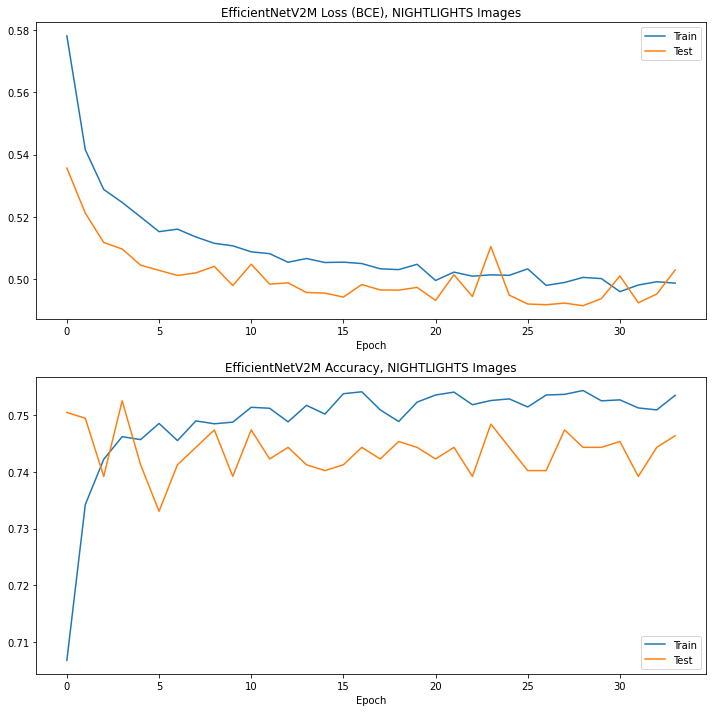

In [ ]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(2,1,1)
ax1.plot(res.history['loss'], label = 'Train')
ax1.plot(res.history['val_loss'], label = 'Test')
plt.title('EfficientNetV2M Loss (BCE), NIGHTLIGHTS Images')
plt.xlabel('Epoch')
plt.legend();

ax2 = plt.subplot(2,1,2)
ax2.plot(res.history['acc'], label = 'Train')
ax2.plot(res.history['val_acc'], label = 'Test')
plt.title('EfficientNetV2M Accuracy, NIGHTLIGHTS Images')
plt.xlabel('Epoch')
plt.legend();
plt.tight_layout();
plt.savefig('../presentation_images/effnet_nightlights')

It looks like this model didn't do much better than the RGB model; its accuracy is about 75%.  However, this is better than the other models!

#### Test that the model saved correctly

In [ ]:
nightlights_model = load_model(f"{model_save_path}/nightlights_classification_effnet_1")

In [ ]:
nightlights_model.evaluate(nl_test_ds)

31/31 [==============================] - 5s 40ms/step - loss: 0.5029 - acc: 0.7464


[0.5028862953186035, 0.7464065551757812]

These are the same scores from before, so everything is working!

# Adding the predicted probabilities from the various models to our dataframes

## Re-making the image dataset generators

To store the predicted probabilities correctly for each image, we now have to re-define the TensorFlow image dataset generators (`rgb_train_ds`, `nl_test_ds`, etc.) that will be used for model evaluation.  This is because, in order to match the predicted probabilites we obtain using `model.predict()` with the names of the images for which those predictions were made, we must use the image dataset generator's `.file_paths` attribute.  But since we initialized the image dataset generator without specifying `shuffle=False`, then the order of the images it generates from the directories *changes* each time we perform any operation (even if we specified a `seed` value!), making the `.file_paths` no longer correctly represent the order in which the neural network processes the image.

Thus, unless we specify `shuffle=False` when creating the image dataset generator, we will not be able to match the CNN models' predictions with the names of the images from which the predictions were made.  We did *not* specify `shuffle=False` when we *trained* the models, as it was important to shuffle the observations to achieve better results: similary-named images come from similar locations, and it is not good to throw too many similar images at the model in a row during training!  However, we now specify `shuffle=False` when we re-make the image dataset generators.

#### NIGHTLIGHTS (needs a different set of code since we have to resize the images)

In [ ]:
NIGHTLIGHTS_image_path = '../data/dhs_images_separated/NIGHTLIGHTS'

In [ ]:
NIGHTLIGHTS_train_ds1 = image_dataset_from_directory(
    f"{nl_image_path}/train",
    label_mode = 'binary',
    batch_size = 32,
    shuffle=False,
    image_size = nl_image_resize
)

Found 17520 files belonging to 2 classes.


In [ ]:
NIGHTLIGHTS_test_ds1 = image_dataset_from_directory(
    f"{nl_image_path}/test",
    label_mode = 'binary',
    batch_size = 32,
    shuffle=False,
    image_size = nl_image_resize
)

Found 974 files belonging to 2 classes.


In [ ]:
NIGHTLIGHTS_val_ds1 = image_dataset_from_directory(
    f"{nl_image_path}/val",
    label_mode = 'binary',
    batch_size = 32,
    shuffle=False,
    image_size = nl_image_resize
)

Found 973 files belonging to 2 classes.


#### RGB, NIR, SWIR1, SWIR2, and TEMP1

In [ ]:
RGB_image_path = '../data/dhs_images_separated/RGB'
NIR_image_path = '../data/dhs_images_separated/NIR'
SWIR1_image_path = '../data/dhs_images_separated/SWIR1'
SWIR2_image_path = '../data/dhs_images_separated/SWIR2'
TEMP1_image_path = '../data/dhs_images_separated/TEMP1'

In [ ]:
channels = ['RGB', 'NIR', 'SWIR1', 'SWIR2', 'TEMP1']
kinds = ['train', 'test', 'val']

for kind, channel in itertools.product(kinds, channels):
    #Get the path to the images from this channel
    image_path = locals()[f"{channel}_image_path"]

    #Make the Tensorflow image dataset generator object for this kind and channel
    locals()[f"{channel}_{kind}_ds1"] =  image_dataset_from_directory(
                                               f"{image_path}/{kind}",
                                               label_mode = 'binary',
                                               batch_size = 32,
                                               shuffle=False,
                                               image_size=[255,255]
                                              )

Found 17520 files belonging to 2 classes.
Found 17520 files belonging to 2 classes.
Found 17520 files belonging to 2 classes.
Found 17520 files belonging to 2 classes.
Found 17520 files belonging to 2 classes.
Found 974 files belonging to 2 classes.
Found 974 files belonging to 2 classes.
Found 974 files belonging to 2 classes.
Found 974 files belonging to 2 classes.
Found 974 files belonging to 2 classes.
Found 973 files belonging to 2 classes.
Found 973 files belonging to 2 classes.
Found 973 files belonging to 2 classes.
Found 973 files belonging to 2 classes.
Found 973 files belonging to 2 classes.


## Make a list of the filenames (in the same order that they will be processed / predicted by our NN models)

#### Get RGB Filenames

In [ ]:
#Get the RGB file paths, which includes files from both the "0" folder and the "1" folder
#(corresponding respectively to those images that are not, or that are, in the poorest third)
rgb_test_filepaths = rgb_test_ds1.file_paths
rgb_test_filepaths[:5]

['../data/dhs_images_separated/RGB/test/0/angola_2011_00-105.jpg',
 '../data/dhs_images_separated/RGB/test/0/angola_2011_00-117.jpg',
 '../data/dhs_images_separated/RGB/test/0/angola_2011_00-121.jpg',
 '../data/dhs_images_separated/RGB/test/0/angola_2011_00-182.jpg',
 '../data/dhs_images_separated/RGB/test/0/angola_2011_00-202.jpg']

In [ ]:
#Extract the file NAMES for the RGB files
rgb_test_filenames = [ s.split('/')[-1].split('.')[0] for s in rgb_test_filepaths]
rgb_test_filenames[:5]

['angola_2011_00-105',
 'angola_2011_00-117',
 'angola_2011_00-121',
 'angola_2011_00-182',
 'angola_2011_00-202']

In [ ]:
#Do the same for the RGB train and val data
for kind in ['train', 'val']:
    locals()[f"rgb_{kind}_filenames"] = [s.split('/')[-1].split('.')[0] for s in locals()[f"rgb_{kind}_ds1"].file_paths]

In [ ]:
#Check that this worked
rgb_val_filenames[:5]

['angola_2011_00-129',
 'angola_2011_00-46',
 'angola_2011_00-59',
 'angola_2011_00-6',
 'angola_2015_00-121']

In [ ]:
#Check that we have the correct number of image names for train, test, and val data
len(rgb_train_filenames), len(rgb_test_filenames), len(rgb_val_filenames)

(17520, 974, 973)

#### Get NIGHLIGHTS file names (and check that they're the same as the RGB ones)

In [ ]:
for kind in ['train', 'test', 'val']:
    locals()[f"nl_{kind}_filenames"] = [s.split('/')[-1].split('.')[0] for s in locals()[f"nl_{kind}_ds1"].file_paths]

In [ ]:
nl_test_filenames[:5]

['angola_2011_00-105',
 'angola_2011_00-117',
 'angola_2011_00-121',
 'angola_2011_00-182',
 'angola_2011_00-202']

These appear to be in the same order as they were for the RGB images, even though the data come from different folders.  Are they all the same?

In [ ]:
( nl_train_filenames == rgb_train_filenames,
 nl_test_filenames == rgb_test_filenames,
 nl_val_filenames == rgb_val_filenames)

(True, True, True)

They are!  So we can use just one list of names for all the image channels - there's no need to extract the names again for the other channels.

In [ ]:
train_filenames = rgb_train_filenames
test_filenames = rgb_test_filenames
val_filenames = rgb_val_filenames

## Add the predicted probabilities of `is_poorest` to our dataframes: an example

In [ ]:
#Get the predicted probabilities (from the RGB model) of is_poorest on the test data
rgb_test_preds = [x[0] for x in rgb_model.predict(rgb_test_ds1)]

#Look at the first 5
rgb_test_preds[:5]

31/31 [==============================] - 2s 56ms/step


[0.36989933, 0.008489091, 0.010736398, 0.09835177, 0.057097726]

In [ ]:
#Make a dictionary mapping image names `angolga_2011_00-123` etc. to predicted probabilities
rgb_test_preds_dict = {test_filenames[i] : rgb_test_preds[i] for i in range(len(test_filenames))}

In [ ]:
#Add this column to our test data dataframe `test`
test['RGB_prob_is_poorest'] = test.index.map(lambda x : rgb_test_preds_dict[x])
test.head()

,country,year,wealth_index,is_urban,households,latitude,longitude,is_poorest,RGB_prob_is_poorest
index,,,,,,,,,
kenya_2014_17-28,kenya,2014.0,-0.199972,1.0,20.0,-0.907212,34.582047,0,0.412457
kenya_2014_31-11,kenya,2014.0,-0.311057,0.0,23.0,0.541424,34.334202,0,0.389613
zimbabwe_2015_00-334,zimbabwe,2015.0,1.621408,1.0,28.0,-18.985624,32.593941,0,0.093095
lesotho_2009_00-370,lesotho,2009.0,-0.373018,0.0,21.0,-29.093271,27.666286,0,0.153861
zambia_2013_00-466,zambia,2013.0,-0.556459,0.0,23.0,-17.476536,26.537828,1,0.394201


In [ ]:
# Add the predictions as single values instead of probabilities
test['RGB_pred'] = test['RGB_prob_is_poorest'].map(lambda x : int(x>.5) )
test.head()

,country,year,wealth_index,is_urban,households,latitude,longitude,is_poorest,RGB_prob_is_poorest,RGB_pred
index,,,,,,,,,,
kenya_2014_17-28,kenya,2014.0,-0.199972,1.0,20.0,-0.907212,34.582047,0,0.412457,0
kenya_2014_31-11,kenya,2014.0,-0.311057,0.0,23.0,0.541424,34.334202,0,0.389613,0
zimbabwe_2015_00-334,zimbabwe,2015.0,1.621408,1.0,28.0,-18.985624,32.593941,0,0.093095,0
lesotho_2009_00-370,lesotho,2009.0,-0.373018,0.0,21.0,-29.093271,27.666286,0,0.153861,0
zambia_2013_00-466,zambia,2013.0,-0.556459,0.0,23.0,-17.476536,26.537828,1,0.394201,0


#### Check that the predictions entered into the dataframe correctly match the index

In [ ]:
#Get the accuracy score on the test data, using Tensorflow
rgb_model.evaluate(rgb_test_ds)

31/31 [==============================] - 2s 64ms/step - loss: 0.5023 - acc: 0.7444


[0.5023045539855957, 0.744353175163269]

In [ ]:
#Check that our dataframe has everything in the right rows,
#by checking that we get the same accuracy score when we compute it manually from the dataframe
metrics.accuracy_score(test['is_poorest'], test['RGB_pred'])

0.74435318275154

We got the same number!  This means that our method correctly matches the RGB model's predictions with the names of the images in the test dataframe.

The loop in the next section applies this method to our `train`, `test`, and `val` dataframes.  However, before proceeding, let's drop the discrete predictions column (`RGB_pred`) from the test dataframe, as we only need the dataframes to contain the predicted *probabilites* from the model.

In [ ]:
test = test.drop(columns='RGB_pred')
test.head(2)

,country,year,wealth_index,is_urban,households,latitude,longitude,is_poorest,RGB_prob_is_poorest
index,,,,,,,,,
kenya_2014_17-28,kenya,2014.0,-0.199972,1.0,20.0,-0.907212,34.582047,0,0.412457
kenya_2014_31-11,kenya,2014.0,-0.311057,0.0,23.0,0.541424,34.334202,0,0.389613


## Add the predicted probabilities of `is_poorest` to our dataframes

While we do this, we will also create a 6x6 dataframe of the loss and accuracy scores of the 6 models on the `train`, `test` and `val` datasets.

In [ ]:
#Make a dictionary of the dataframes
dfs_dict = {
   'train':train,
   'test':test,
   'val':val
}

#Make a dictionary of the models' names
models_dict = {
    'RGB' : rgb_model,
    'NIR': NIR_model,
    'SWIR1': SWIR1_model,
    'SWIR2': SWIR2_model,
    'TEMP1': TEMP1_model,
    'NIGHTLIGHTS': nightlights_model
}


In [ ]:
#Initialize a dictionary to store accuracy and loss scores
results_dict = { channel : {} for channel in models_dict.keys()}

#Loop over train/test/val and the 6 types of images
for channel in models_dict.keys():
  for kind in dfs_dict.keys():

    #Let ds be the image data generator for this kind and channel
    ds = locals()[f"{channel}_{kind}_ds1"]

    #Get the model for this channel
    model = models_dict[channel]

    #Get a list of predicted probabilities from the model for this channel
    preds = [x[0] for x in model.predict(ds)]

    #Get the image filenames for this kind (train, test, or val)
    filenames = locals()[f"{kind}_filenames"]

    #Make a dictionary mapping image names to predicted probabilities
    preds_dict = {filenames[i] : preds[i] for i in range(len(filenames))}

    #Add this dict as a column in the appropriate kind of dataframe
    dfs_dict[kind][f"{channel}_prob_is_poorest"] = dfs_dict[kind].index.map(lambda x : preds_dict[x])

    #While we're at it, store the accuracy and loss scores
    loss, acc = model.evaluate(ds)
    results_dict[channel][f"{kind}_loss"] = loss
    results_dict[channel][f"{kind}_acc"] = acc


#Turn the accuracy and loss results into a dataframe
results_df = pd.DataFrame(results_dict).T

31/31 [==============================] - 1s 42ms/step - loss: 0.4605 - acc: 0.7646


#### Check that it worked

In [ ]:
train.head(2)

,country,year,wealth_index,is_urban,households,latitude,longitude,is_poorest,RGB_prob_is_poorest,SWIR1_prob_is_poorest,TEMP1_prob_is_poorest,NIGHTLIGHTS_prob_is_poorest,NIR_prob_is_poorest,SWIR2_prob_is_poorest
index,,,,,,,,,,,,,,
lesotho_2014_00-254,lesotho,2014.0,0.983558,1.0,24.0,-28.909042,27.936529,0,0.062643,0.127830,0.187977,0.036982,0.071136,0.143754
burkina_faso_2010_00-162,burkina_faso,2010.0,-0.604069,0.0,25.0,11.163129,-3.322228,1,0.399560,0.303285,0.315730,0.656919,0.228373,0.384060


In [ ]:
test.head(2)

,country,year,wealth_index,is_urban,households,latitude,longitude,is_poorest,RGB_prob_is_poorest,NIR_prob_is_poorest,SWIR1_prob_is_poorest,SWIR2_prob_is_poorest,TEMP1_prob_is_poorest,NIGHTLIGHTS_prob_is_poorest
index,,,,,,,,,,,,,,
kenya_2014_17-28,kenya,2014.0,-0.199972,1.0,20.0,-0.907212,34.582047,0,0.412457,0.124123,0.087208,0.223013,0.472909,0.164352
kenya_2014_31-11,kenya,2014.0,-0.311057,0.0,23.0,0.541424,34.334202,0,0.389613,0.162249,0.141361,0.328533,0.069650,0.326112


In [ ]:
val.head(2)

,country,year,wealth_index,is_urban,households,latitude,longitude,is_poorest,RGB_prob_is_poorest,NIR_prob_is_poorest,SWIR1_prob_is_poorest,SWIR2_prob_is_poorest,TEMP1_prob_is_poorest,NIGHTLIGHTS_prob_is_poorest
index,,,,,,,,,,,,,,
benin_2012_00-615,benin,2012.0,1.306931,0.0,21.0,6.384848,2.478482,0,0.049109,0.017400,0.074836,0.055886,0.036021,0.054802
rwanda_2010_00-87,rwanda,2010.0,1.076257,1.0,26.0,-1.953650,30.139626,0,0.038193,0.043351,0.029069,0.014364,0.076905,0.050861


In [ ]:
results_df.index.name = 'image_type'
results_df

,train_loss,train_acc,test_loss,test_acc,val_loss,val_acc
image_type,,,,,,
RGB,0.493132,0.740925,0.502304,0.744353,0.498364,0.741007
NIR,0.527630,0.720434,0.562236,0.689938,0.535320,0.707091
SWIR1,0.521002,0.726142,0.539058,0.712526,0.535991,0.706064
SWIR2,0.510662,0.734874,0.545634,0.706366,0.527320,0.719424
TEMP1,0.563197,0.701598,0.569696,0.696099,0.562375,0.698869
NIGHTLIGHTS,0.489110,0.755365,0.502890,0.746407,0.460500,0.764645


#### Export the dataframes with predicted probabilities

In [ ]:
csv_export_folder = '../data/NN_results_csvs'

train.to_csv(f"{csv_export_folder}/train.csv", index_label='index')
test.to_csv(f"{csv_export_folder}/test.csv", index_label='index')
val.to_csv(f"{csv_export_folder}/val.csv", index_label='index')

#### Export the loss and accuracy results dataframe



In [ ]:
results_df.to_csv(f"{csv_export_folder}/nn_results.csv", index_label='image_type')

# What's next?

In the [next notebook](./06_final_modeling.ipynb), we use the outputs of our Neural Network models, along with other varaibles, as features.  We build ensemble models and select the best performer as our production model.